In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df['sentiment'] = np.where(df['sentiment'] == "positive", 1, 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Text(0, 0.5, 'Count')

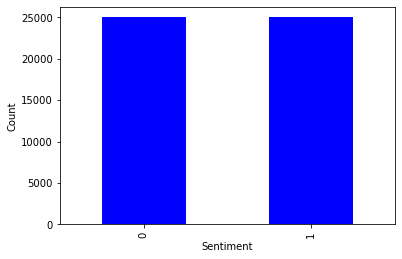

In [4]:
df['sentiment'].value_counts().sort_index().plot(kind='bar',color = 'blue')
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [5]:
df = df.sample(frac=0.1, random_state=0) 
df.dropna(inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'],test_size=0.1, random_state=0)

In [7]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    text = BeautifulSoup(raw_text, 'html.parser').get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = letters_only.lower().split() 
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True:

        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:
        return (words)
    
    return( " ".join(words))

In [8]:
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from bs4 import BeautifulSoup 
import logging
from wordcloud import WordCloud
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 the crimson rivers is one of the most over directed over the top over everything mess i ve ever seen come out of france there s nothing worse than a french production trying to out do films made in hollywood and cr is a perfect example of such a wannabe horror action buddy flick i almost stopped it halfway through because i knew it wouldn t amount to anything but french guys trying to show off the film starts off promisingly like some sort of expansive horror film but it quickly shifts genres from horror to action to x files type to buddy flick that in the end cr is all of it and also none of it it s so full of clich s that at one point i thought the whole thing was a comedy the painful dialogue and those silent pauses with fades outs and fades ins just at the right expositionary moments made me groan i thought only films made in hollywood used this hackneyed technique the chase scene with vincent cassel running after the killer is so over 

## CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 36751 

Show some feature names : 
 ['aa', 'ameche', 'auggie', 'betrayals', 'bright', 'cathryn', 'clownhouse', 'copying', 'dazzle', 'disarray', 'dvd', 'estimation', 'fighter', 'fusion', 'greenfinch', 'henson', 'imaginings', 'ir', 'kint', 'linklater', 'maropis', 'misik', 'nectar', 'organise', 'performing', 'pre', 'rages', 'reputedly', 'saddled', 'sexiness', 'smith', 'steal', 'swoozie', 'tinfoil', 'unattuned', 'vernacular', 'willed']


MultinomialNB()

In [11]:
import pickle
pickle.dump(countVect,open('countVect_imdb.pkl','wb'))

In [12]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [13]:
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8140

AUC score : 0.8142

Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.86      0.82       249
           1       0.85      0.77      0.81       251

    accuracy                           0.81       500
   macro avg       0.82      0.81      0.81       500
weighted avg       0.82      0.81      0.81       500


Confusion Matrix : 
 [[214  35]
 [ 58 193]]


In [14]:
import pickle
pickle.dump(mnb,open('Naive_Bayes_model_imdb.pkl','wb'))

# TfidfVectorizer with Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 10505 

Show some feature names : 
 ['00', 'belonged', 'completion', 'dubious', 'garbage', 'interviewing', 'million', 'plays', 'rough', 'strike', 'vein']


LogisticRegression()

In [16]:
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['bad' 'worst' 'awful' 'no' 'waste' 'poor' 'terrible' 'boring' 'even'
 'minutes']

Top 10 features with largest coefficients : 
['great' 'and' 'excellent' 'best' 'it' 'wonderful' 'very' 'also' 'well'
 'love']


In [17]:
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8500

AUC score : 0.8500

Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       249
           1       0.85      0.85      0.85       251

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500


Confusion Matrix : 
 [[211  38]
 [ 37 214]]


In [18]:
from sklearn.model_selection import  GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


params = {"lr__C":[0.1, 1, 10], 
          "tfidf__min_df": [1, 3], 
          "tfidf__max_features": [1000, None], 
          "tfidf__ngram_range": [(1,1), (1,2)], 
          "tfidf__stop_words": [None, "english"]} 

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.8720

AUC score : 0.8720

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       249
           1       0.87      0.88      0.87       251

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500


Confusion Matrix : 
 [[216  33]
 [ 31 220]]


# Word2Vec
<br>

**Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)**

**Step 2 : Create volcabulary list using Word2Vec model.**

**Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein.**

**Step 4 : Fit the average feature vectors to Random Forest Classifier.**

In [19]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):

    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer,remove_stopwords=False)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

4500 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['the', 'crimson', 'rivers', 'is', 'one', 'of', 'the', 'most', 'over', 'directed', 'over', 'the', 'top', 'over', 'everything', 'mess', 'i', 've', 'ever', 'seen', 'come', 'out', 'of', 'france', 'there', 's', 'nothing', 'worse', 'than', 'a', 'french', 'production', 'trying', 'to', 'out', 'do', 'films', 'made', 'in', 'hollywood', 'and', 'cr', 'is', 'a', 'perfect', 'example', 'of', 'such', 'a', 'wannabe', 'horror', 'action', 'buddy', 'flick', 'i', 'almost', 'stopped', 'it', 'halfway', 'through', 'because', 'i', 'knew', 'it', 'wouldn', 't', 'amount', 'to', 'anything', 'but', 'french', 'guys', 'trying', 'to', 'show', 'off', 'the', 'film', 'starts', 'off', 'promisingly', 'like', 'some', 'sort', 'of', 'expansive', 'horror', 'film', 'but', 'it', 'quickly', 'shifts', 'genres', 'from', 'horror', 'to', 'action', 'to', 'x', 'files', 'type', 'to', 'buddy', 'flick', 'that', 'in', 'the', 'end', 'cr', 'is', 'all', 

## Creating Volcabulary List usinhg Word2Vec Model

In [21]:
from wordcloud import WordCloud
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors
num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...



AttributeError: The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

## Averaging Feature Vectors

In [22]:
def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [23]:
def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [24]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

AttributeError: The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

# Random Forest Classifer

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)

NameError: name 'trainVector' is not defined

## LSTM
<br>

**Step 1 : Prepare X_train and X_test to 2D tensor.**
    
**Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer).**
    
**Step 3 : Compile and fit the model using log loss function and ADAM optimizer.**

In [ ]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [ ]:
top_words = 40000 
maxlen = 200 
batch_size = 62
nb_classes = 4
nb_epoch = 6


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)
print("========================================")
print('X_test shape:', X_test_seq.shape)
print("========================================")
print('y_train shape:', y_train_seq.shape)
print("========================================")
print('y_test shape:', y_test_seq.shape)
print("========================================")

X_train shape: (4500, 200)
X_test shape: (500, 200)
y_train shape: (4500, 4)
y_test shape: (500, 4)


In [ ]:
model1 = Sequential()
model1.add(Embedding(top_words, 128, dropout=0.2))
model1.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 5,252,100
Trainable params: 5,252,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Epoch 1/6
4500/4500 [==============================] - 22s 5ms/step - loss: 0.3760 - accuracy: 0.7594
Epoch 2/6
4500/4500 [==============================] - 24s 5ms/step - loss: 0.2857 - accuracy: 0.8577
Epoch 3/6
4500/4500 [==============================] - 24s 5ms/step - loss: 0.1591 - accuracy: 0.9347
Epoch 4/6
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0838 - accuracy: 0.9699
Epoch 5/6
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0385 - accuracy: 0.9874
Epoch 6/6
500/500 [==============================] - 1s 1ms/step
Test loss : 0.4559
Test accuracy : 0.8750


In [ ]:
len(X_train_seq),len(y_train_seq)

(4500, 4500)

In [ ]:
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape)

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape)

Size of weight matrix in the embedding layer :  (40000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 4)


In [ ]:
import pickle
pickle.dump(model1,open('model1.pkl','wb'))

## LSTM with Word2Vec Embedding

In [ ]:
2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")

embedding_matrix = w2v.wv.syn0 
print("Shape of embedding matrix : ", embedding_matrix.shape)

In [ ]:
top_words = embedding_matrix.shape[0] #4016 
maxlen = 300 
batch_size = 62
nb_classes = 4
nb_epoch = 7


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq1 = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq1 = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq1 = np_utils.to_categorical(y_train, nb_classes)
y_test_seq1 = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq1.shape)
print("========================================")
print('X_test shape:', X_test_seq1.shape)
print("========================================")
print('y_train shape:', y_train_seq1.shape)
print("========================================")
print('y_test shape:', y_test_seq1.shape)
print("========================================")

In [ ]:
len(X_train_seq1),len(y_train_seq1)

In [ ]:
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])

model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq1, y_train_seq1, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evaluation
score = model2.evaluate(X_test_seq1, y_test_seq1, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

In [ ]:
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) 

print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) 

print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) 